# This notebook compares the outputs from VESIcal to the excel spreadsheet provided by Allison
- This notebook relies on the Excel spreadsheet entitled: "Testing_Moore_et_al_1998.xlsx"
- Test 0 - looks into why so many Nans returned
- Test 1 compares saturation pressures from the Allison spreadsheet for the sunset crater composition at 2000 ppm CO$_2$ and variable melt H$_2$O contents - CURRENT STATUS - FAIL
- Test 2 compares saturation pressures from the Allison spreadsheet for the sunset crater composition at 500 ppm CO$_2$ and variable melt H$_2$O contents - CURRENT STATUS - OKAY AT LOW H2O CONTENTS
- Test 3 compares saturation pressures from the Allison spreadsheet for the sunset crater composition at 5000 ppm CO$_2$ and variable melt H$_2$O contents - CURRENT STATUS  - FAIL
- Test 4 checks whether Allison Carbon and other models are actually sensitive to CO2. Seems not. Or is the problem that Allison Carbon isn't returning any results, so just getting the minimal effect of the H2O. 

In [1]:
import VESIcal as v
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [2]:
plt.rcParams["font.family"] = 'arial'
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
%matplotlib inline
sns.set(style="ticks", context="poster",rc={"grid.linewidth": 1,"xtick.major.width": 1,"ytick.major.width": 1, 'patch.edgecolor': 'black'})

plt.style.use("seaborn-colorblind")
#jtplot.style()
mpl.rcParams['patch.linewidth'] = 1
mpl.rcParams['axes.linewidth'] = 1 # set the value globally

In [120]:
# Test 0 why AllisonCarbon returns Nans so often
# Why so many Nans
my_sample = {'SiO2':  48.21,
             'TiO2':  1.86, 
             'Al2O3': 16.44,
             'Fe2O3':  0,
             'Cr2O3':  0.0,
             'FeO':    9.92,
             'MnO':    0.18,
             'MgO':    8.58,
             'NiO':    0.0,
             'CoO':    0.0,
             'CaO':    10.06,
             'Na2O':   3.46,
             'K2O':    0.82,
             'P2O5':   0.47,
             'H2O':    36,
             'CO2':    0.1}
test=v.calculate_saturation_pressure(sample=my_sample, temperature=1200, verbose=True, model='AllisonCarbon', fit='thermodynamic', loc='sunset').result
#test
# Doesn't ever seem to return a Nan for CO2<0.04 wt% 
# Return Nan if H2O<1 wt%, CO2=0.05 wt%
# Return Nan if H2O<5 wt%, CO2=0.06 wt%
# Return Nan if H2O<11 wt%, CO2=0.07 wt%
# Return Nan if H2O<17 wt%, CO2=0.08 wt%
# Return Nan if H2O<36 wt%, CO2=0.1 wt%
test

947.5101201410979

## Setting up all the different possible mixed fluid models

In [3]:
mixed_model_ConstantCarbon_Moore = v.MixedFluid({'CO2':v.AllisonCarbon(model_fit='thermodynamic', model_loc='sunset'),
                            'H2O':v.MooreWater()})
mixed_model_ConstantCarbon_Dixon = v.MixedFluid({'CO2':v.AllisonCarbon(model_fit='thermodynamic', model_loc='sunset'),
                            'H2O':v.DixonWater()})
mixed_model_ConstantCarbon_Liu = v.MixedFluid({'CO2':v.AllisonCarbon(model_fit='thermodynamic', model_loc='sunset'),
                            'H2O':v.LiuWater()})
mixed_model_ConstantCarbon_Shish = v.MixedFluid({'CO2':v.AllisonCarbon(model_fit='thermodynamic', model_loc='sunset'),
                            'H2O':v.ShishkinaWater()})
mixed_model_ConstantCarbon_Iacono = v.MixedFluid({'CO2':v.AllisonCarbon(model_fit='thermodynamic', model_loc='sunset'),
                            'H2O':v.IaconoMarzianoWater()})

# Test 1 - Saturation pressures for variable water, 2000 ppm CO$_2$ (Sunset Crater)
- the spreadsheet uses the SunsetCrater composition, for 2000 ppm CO2, and varying water contents, and compares it to VESIcal saturation pressures

In [122]:
myfile= v.ExcelFile('Testing_Allison_et_al_2019.xlsx',   input_type='wtpercent', sheet_name='SunsetCrater_2000ppm')
data = myfile.data
data.head()

,SiO2,TiO2,Al2O3,Fe2O3,Cr2O3,FeO,MnO,MgO,NiO,CoO,CaO,Na2O,K2O,P2O5,H2O,CO2,Press,Temp
Label,,,,,,,,,,,,,,,,,,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,0.0,0.2,2674,1200
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,0.5,0.2,2691,1200
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,1.0,0.2,2736,1200
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,1.5,0.2,2804,1200
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,2.0,0.2,2894,1200


In [123]:
satPs_wtemps_Allison_Carbon=myfile.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon', loc='sunset', fit='thermodynamic')

/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:5071: RuntimeWarning: Saturation pressure not found.
  warnings.warn("Saturation pressure not found.",RuntimeWarning)


## Saturation pressures

In [6]:
#Moore
satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore=myfile.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Moore)
#Dixon
satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon=myfile.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Dixon)
#Liu
satPs_wtemps_Allison_ConstantCarbon_Mixed_Liu=myfile.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Liu)
# Shishkina
satPs_wtemps_Allison_ConstantCarbon_Mixed_Shish=myfile.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Shish)
# Iacono
satPs_wtemps_Allison_ConstantCarbon_Mixed_Iacono=myfile.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Iacono)


/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:4387: RuntimeWarning: divide by zero encountered in log
  two_ln_XH2Omelt = (aParam / temperatureK) + b_x_sum * (pressure/temperatureK) + cParam * np.log(fH2O) + dParam
/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:4387: RuntimeWarning: invalid value encountered in log
  two_ln_XH2Omelt = (aParam / temperatureK) + b_x_sum * (pressure/temperatureK) + cParam * np.log(fH2O) + dParam
/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:3381: RuntimeWarning: Saturation pressure not found.
  warnings.warn("Saturation pressure not found.",RuntimeWarning)


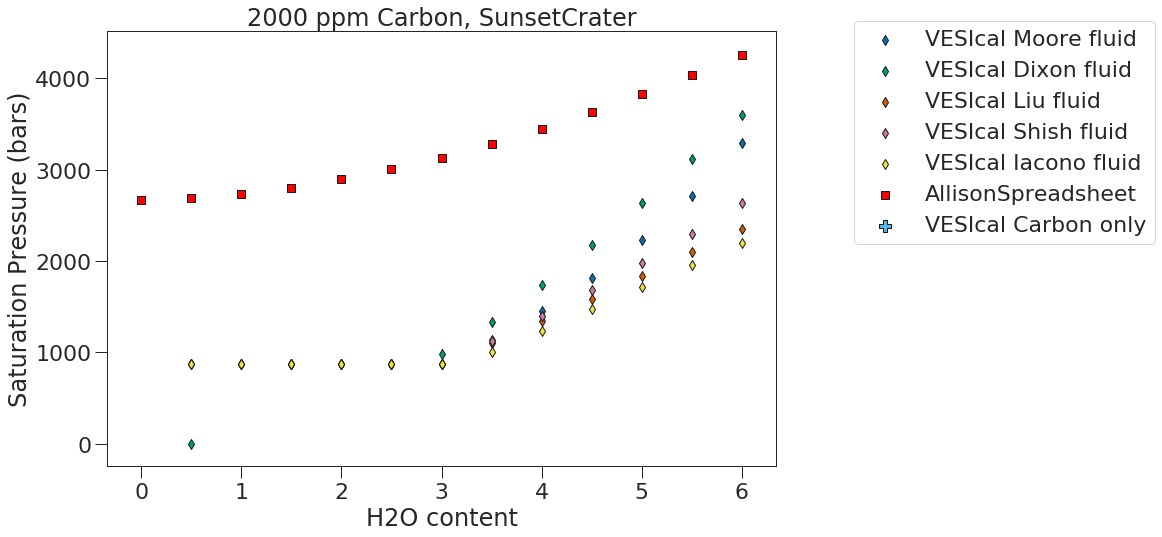

In [7]:
fig, ax1 = plt.subplots(figsize = (12,8)) # adjust dimensions of figure here

plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore['SaturationP_bars_VESIcal'], s=50, label='VESIcal Moore fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon['SaturationP_bars_VESIcal'], s=50,label='VESIcal Dixon fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Liu['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Liu['SaturationP_bars_VESIcal'], s=50,label='VESIcal Liu fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Shish['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Shish['SaturationP_bars_VESIcal'], s=50,label='VESIcal Shish fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Iacono['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Iacono['SaturationP_bars_VESIcal'],s=50, label='VESIcal Iacono fluid', marker='d', edgecolor='k')

plt.scatter(satPs_wtemps_Allison_Carbon['H2O'], satPs_wtemps_Allison_Carbon['Press'], marker='s', s=80,  c='red', edgecolor='k', label='AllisonSpreadsheet', zorder=5 )
plt.scatter(satPs_wtemps_Allison_Carbon['H2O'], satPs_wtemps_Allison_Carbon['SaturationP_bars_VESIcal'], label='VESIcal Carbon only', marker='P', edgecolor='k')
plt.legend()
plt.xlabel('H2O content')
plt.ylabel('Saturation Pressure (bars)')
plt.title('2000 ppm Carbon, SunsetCrater')
ax1.legend(bbox_to_anchor=(1.1, 1.05))

# Test 2 - Saturation pressures for variable water, 500 ppm CO$_2$ (Sunset Crater)

In [35]:
myfile_500= v.ExcelFile('Testing_Allison_et_al_2019.xlsx',   input_type='wtpercent', sheet_name='SunsetCrater_500ppm')
data_500 = myfile_500.data
data_500.head()

,SiO2,TiO2,Al2O3,Fe2O3,Cr2O3,FeO,MnO,MgO,NiO,CoO,CaO,Na2O,K2O,P2O5,H2O,CO2,Press,Temp
Label,,,,,,,,,,,,,,,,,,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,0.0,0.05,799,1200
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,0.5,0.05,824,1200
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,1.0,0.05,889,1200
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,1.5,0.05,988,1200
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,2.0,0.05,1119,1200


In [36]:
#Just Allison Carbon
satPs_wtemps_Allison_Carbon_500=myfile_500.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon', loc='sunsetcrater', fit='thermodynamic')
#Moore
satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore_500=myfile_500.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Moore)
#Dixon
satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon_500=myfile_500.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Dixon)
#Liu
satPs_wtemps_Allison_ConstantCarbon_Mixed_Liu_500=myfile_500.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Liu)
# Shishkina
satPs_wtemps_Allison_ConstantCarbon_Mixed_Shish_500=myfile_500.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Shish)
# Iacono
satPs_wtemps_Allison_ConstantCarbon_Mixed_Iacono_500=myfile_500.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Iacono)


/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:5071: RuntimeWarning: Saturation pressure not found.
  warnings.warn("Saturation pressure not found.",RuntimeWarning)
/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:4387: RuntimeWarning: divide by zero encountered in log
  two_ln_XH2Omelt = (aParam / temperatureK) + b_x_sum * (pressure/temperatureK) + cParam * np.log(fH2O) + dParam
/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:4387: RuntimeWarning: invalid value encountered in log
  two_ln_XH2Omelt = (aParam / temperatureK) + b_x_sum * (pressure/temperatureK) + cParam * np.log(fH2O) + dParam
/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:3381: RuntimeWarning: Saturation pressure not found.
  warnings.warn("Saturation pressure not found.",RuntimeWarning)


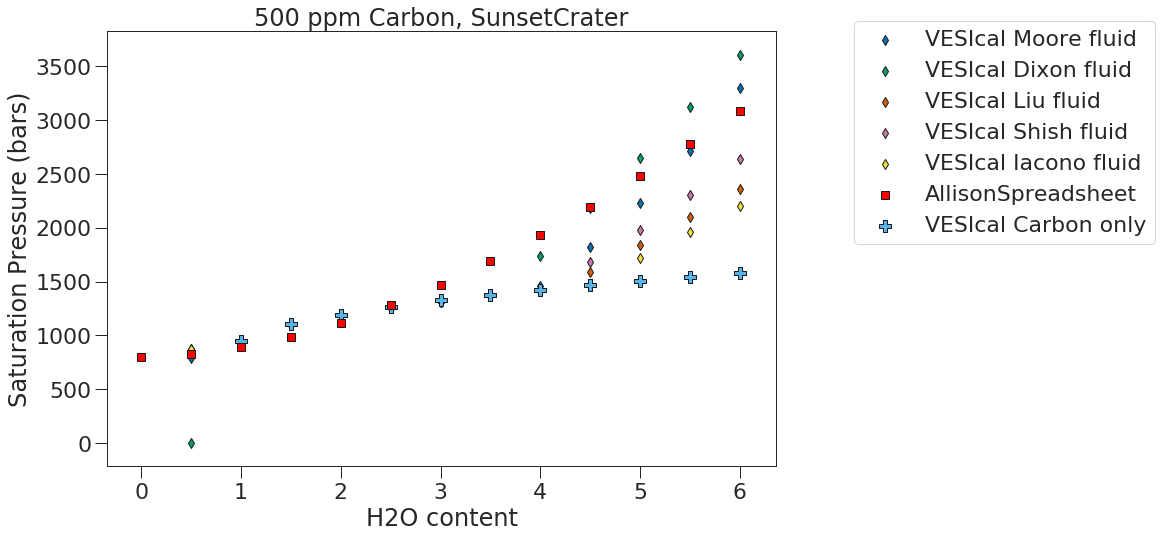

In [37]:
fig, ax1 = plt.subplots(figsize = (12,8)) # adjust dimensions of figure here

plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore_500['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore_500['SaturationP_bars_VESIcal'], s=50, label='VESIcal Moore fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon_500['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon_500['SaturationP_bars_VESIcal'], s=50,label='VESIcal Dixon fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Liu_500['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Liu_500['SaturationP_bars_VESIcal'], s=50,label='VESIcal Liu fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Shish_500['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Shish_500['SaturationP_bars_VESIcal'], s=50,label='VESIcal Shish fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Iacono_500['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Iacono_500['SaturationP_bars_VESIcal'],s=50, label='VESIcal Iacono fluid', marker='d', edgecolor='k')

plt.scatter(satPs_wtemps_Allison_Carbon_500['H2O'], satPs_wtemps_Allison_Carbon_500['Press'], marker='s', s=80,  c='red', edgecolor='k', label='AllisonSpreadsheet', zorder=5 )
plt.scatter(satPs_wtemps_Allison_Carbon_500['H2O'], satPs_wtemps_Allison_Carbon_500['SaturationP_bars_VESIcal'], label='VESIcal Carbon only', marker='P', edgecolor='k')
plt.legend()
plt.xlabel('H2O content')
plt.ylabel('Saturation Pressure (bars)')
plt.title('500 ppm Carbon, SunsetCrater')
ax1.legend(bbox_to_anchor=(1.1, 1.05))

In [40]:
satPs_wtemps_Allison_Carbon_500

,SiO2,TiO2,Al2O3,Fe2O3,Cr2O3,FeO,MnO,MgO,NiO,CoO,...,Na2O,K2O,P2O5,H2O,CO2,Press,Temp,SaturationP_bars_VESIcal,Model,Warnings
Label,,,,,,,,,,,,,,,,,,,,,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,0.0,0.05,799,1200,NaN,AllisonCarbon,The pressure is outside the calibration range ...
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,0.5,0.05,824,1200,NaN,AllisonCarbon,The pressure is outside the calibration range ...
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,1.0,0.05,889,1200,947.844021,AllisonCarbon,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,1.5,0.05,988,1200,1102.383362,AllisonCarbon,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,2.0,0.05,1119,1200,1192.709418,AllisonCarbon,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,2.5,0.05,1280,1200,1263.860228,AllisonCarbon,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,3.0,0.05,1470,1200,1324.227563,AllisonCarbon,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,3.5,0.05,1687,1200,1377.306016,AllisonCarbon,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,4.0,0.05,1929,1200,1424.973497,AllisonCarbon,


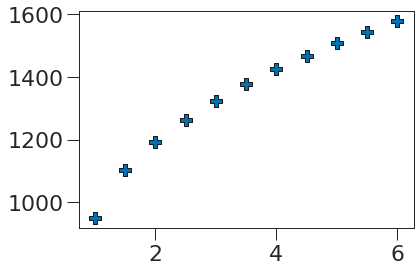

In [39]:
plt.scatter(satPs_wtemps_Allison_Carbon_500['H2O'], satPs_wtemps_Allison_Carbon_500['SaturationP_bars_VESIcal'], label='VESIcal Carbon only', marker='P', edgecolor='k')

# Test 3 - Saturation pressures for variable water, 5000 ppm CO$_2$ (Sunset Crater)

In [32]:
myfile_5000= v.ExcelFile('Testing_Allison_et_al_2019.xlsx',   input_type='wtpercent', sheet_name='SunsetCrater_5000ppm')
data_5000 = myfile_5000.data
data_5000.head()

,SiO2,TiO2,Al2O3,Fe2O3,Cr2O3,FeO,MnO,MgO,NiO,CoO,CaO,Na2O,K2O,P2O5,H2O,CO2,Press,Temp
Label,,,,,,,,,,,,,,,,,,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,0.0,0.5,5121,1200
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,0.5,0.5,5132,1200
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,1.0,0.5,5159,1200
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,1.5,0.5,5201,1200
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,2.0,0.5,5257,1200


In [33]:
#Just Allison Carbon
satPs_wtemps_Allison_Carbon_5000=myfile_5000.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon', loc='sunset', fit='thermodynamic')
#Moore
satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore_5000=myfile_5000.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Moore)
#Dixon
satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon_5000=myfile_5000.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Dixon)
#Liu
satPs_wtemps_Allison_ConstantCarbon_Mixed_Liu_5000=myfile_5000.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Liu)
# Shishkina
satPs_wtemps_Allison_ConstantCarbon_Mixed_Shish_5000=myfile_5000.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Shish)
# Iacono
satPs_wtemps_Allison_ConstantCarbon_Mixed_Iacono_5000=myfile_5000.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Iacono)


/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:5071: RuntimeWarning: Saturation pressure not found.
  warnings.warn("Saturation pressure not found.",RuntimeWarning)
/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:4387: RuntimeWarning: divide by zero encountered in log
  two_ln_XH2Omelt = (aParam / temperatureK) + b_x_sum * (pressure/temperatureK) + cParam * np.log(fH2O) + dParam
/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:4387: RuntimeWarning: invalid value encountered in log
  two_ln_XH2Omelt = (aParam / temperatureK) + b_x_sum * (pressure/temperatureK) + cParam * np.log(fH2O) + dParam
/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:3381: RuntimeWarning: Saturation pressure not found.
  warnings.warn("Saturation pressure not found.",RuntimeWarning)


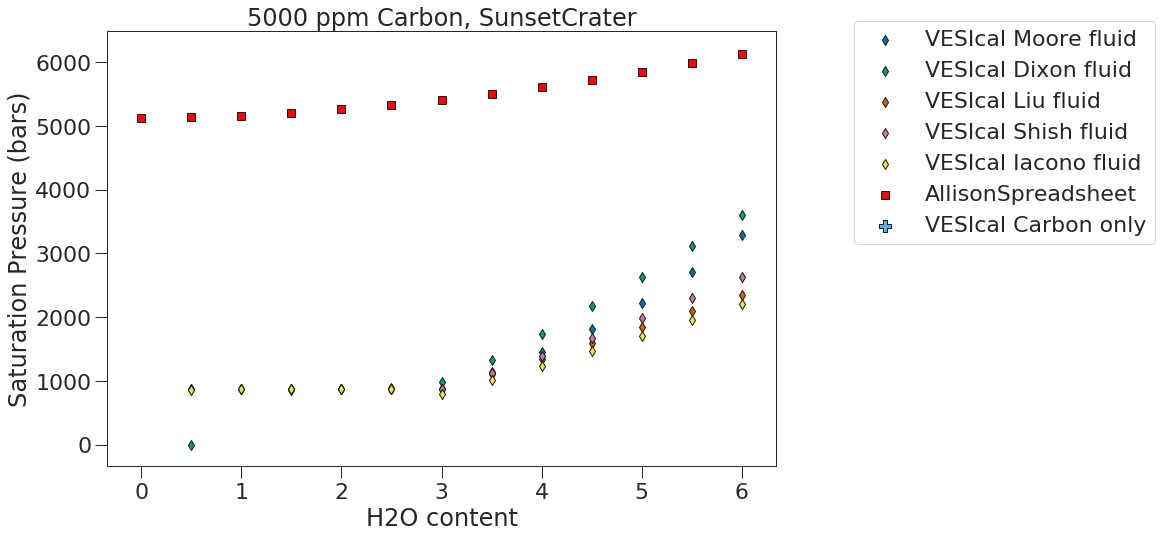

In [34]:
fig, ax1 = plt.subplots(figsize = (12,8)) # adjust dimensions of figure here

plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore_5000['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore_5000['SaturationP_bars_VESIcal'], s=50, label='VESIcal Moore fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon_5000['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon_5000['SaturationP_bars_VESIcal'], s=50,label='VESIcal Dixon fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Liu_5000['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Liu_5000['SaturationP_bars_VESIcal'], s=50,label='VESIcal Liu fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Shish_5000['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Shish_5000['SaturationP_bars_VESIcal'], s=50,label='VESIcal Shish fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Iacono_5000['H2O'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Iacono_5000['SaturationP_bars_VESIcal'],s=50, label='VESIcal Iacono fluid', marker='d', edgecolor='k')

plt.scatter(satPs_wtemps_Allison_Carbon_5000['H2O'], satPs_wtemps_Allison_Carbon_5000['Press'], marker='s', s=80,  c='red', edgecolor='k', label='AllisonSpreadsheet', zorder=5 )
plt.scatter(satPs_wtemps_Allison_Carbon_5000['H2O'], satPs_wtemps_Allison_Carbon_5000['SaturationP_bars_VESIcal'], label='VESIcal Carbon only', marker='P', edgecolor='k')
plt.legend()
plt.xlabel('H2O content')
plt.ylabel('Saturation Pressure (bars)')
plt.title('5000 ppm Carbon, SunsetCrater')
ax1.legend(bbox_to_anchor=(1.1, 1.05))

# Test 4 - does vesical actually care about carbon?!

/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:5071: RuntimeWarning: Saturation pressure not found.
  warnings.warn("Saturation pressure not found.",RuntimeWarning)


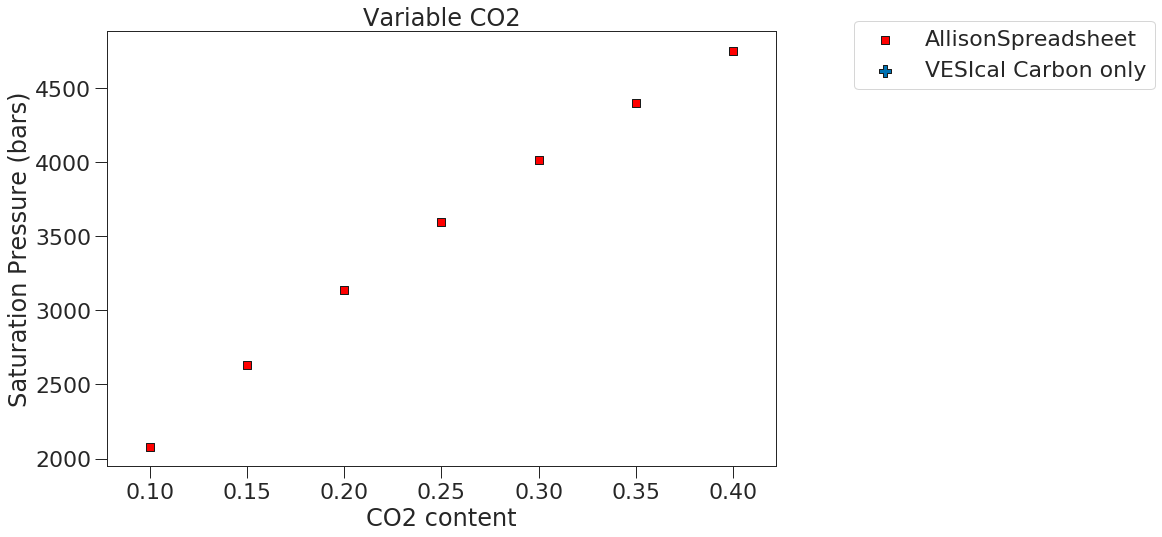

In [41]:
# Just C no H2O
myfile_VC1= v.ExcelFile('Testing_Allison_et_al_2019.xlsx',   input_type='wtpercent', sheet_name='SunsetCrater_VariableCarbon_0W')
data_VC1 = myfile_VC.data
data_VC1.head()
satPs_wtemps_Allison_Carbon_VC1=myfile_VC1.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon', fit='thermodynamic')
fig, ax1 = plt.subplots(figsize = (12,8)) # adjust dimensions of figure here

plt.scatter(data_VC1['CO2'], data_VC1['Press'], marker='s', s=80,  c='red', edgecolor='k', label='AllisonSpreadsheet', zorder=5 )
plt.scatter(satPs_wtemps_Allison_Carbon_VC1['CO2'], satPs_wtemps_Allison_Carbon_VC1['SaturationP_bars_VESIcal'], label='VESIcal Carbon only', marker='P', edgecolor='k')
plt.legend()
plt.xlabel('CO2 content')
plt.ylabel('Saturation Pressure (bars)')
plt.title('Variable CO2')
ax1.legend(bbox_to_anchor=(1.1, 1.05))

In [42]:
myfile_VC= v.ExcelFile('Testing_Allison_et_al_2019.xlsx',   input_type='wtpercent', sheet_name='SunsetCrater_VariableCarbon_3W')
data_VC = myfile_VC.data
data_VC.head()

,SiO2,TiO2,Al2O3,Fe2O3,Cr2O3,FeO,MnO,MgO,NiO,CoO,CaO,Na2O,K2O,P2O5,H2O,CO2,Press,Temp,CO2ppm
Label,,,,,,,,,,,,,,,,,,,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,3,0.10,2081,1200,1000
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,3,0.15,2632,1200,1500
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,3,0.20,3134,1200,2000
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,3,0.25,3593,1200,2500
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,10.06,3.46,0.82,0.47,3,0.30,4018,1200,3000


In [43]:
#Just Allison Carbon
satPs_wtemps_Allison_Carbon_VC=myfile_VC.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon', loc='sunset', fit='thermodynamic')
#Moore
satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore_VC=myfile_VC.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Moore)
#Dixon
satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon_VC=myfile_VC.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Dixon)
#Liu
satPs_wtemps_Allison_ConstantCarbon_Mixed_Liu_VC=myfile_VC.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Liu)
# Shishkina
satPs_wtemps_Allison_ConstantCarbon_Mixed_Shish_VC=myfile_VC.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Shish)
# Iacono
satPs_wtemps_Allison_ConstantCarbon_Mixed_Iacono_VC=myfile_VC.calculate_saturation_pressure(temperature="Temp", model=mixed_model_ConstantCarbon_Iacono)


/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:5071: RuntimeWarning: Saturation pressure not found.
  warnings.warn("Saturation pressure not found.",RuntimeWarning)
/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:4387: RuntimeWarning: divide by zero encountered in log
  two_ln_XH2Omelt = (aParam / temperatureK) + b_x_sum * (pressure/temperatureK) + cParam * np.log(fH2O) + dParam


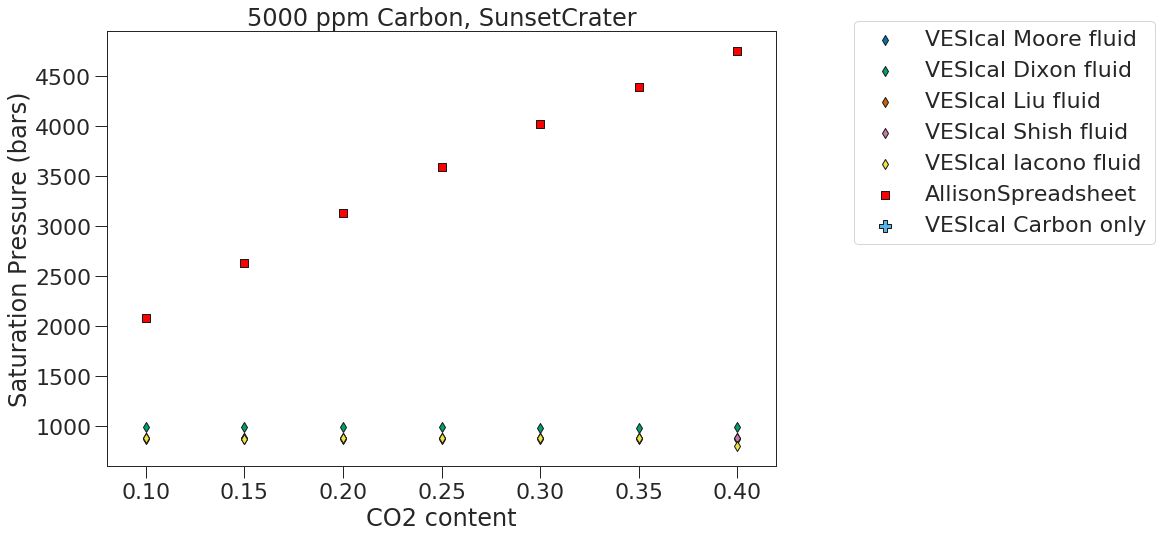

In [44]:
fig, ax1 = plt.subplots(figsize = (12,8)) # adjust dimensions of figure here

plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore_VC['CO2'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore_VC['SaturationP_bars_VESIcal'], s=50, label='VESIcal Moore fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon_VC['CO2'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon_VC['SaturationP_bars_VESIcal'], s=50,label='VESIcal Dixon fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Liu_VC['CO2'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Liu_VC['SaturationP_bars_VESIcal'], s=50,label='VESIcal Liu fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Shish_VC['CO2'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Shish_VC['SaturationP_bars_VESIcal'], s=50,label='VESIcal Shish fluid', marker='d', edgecolor='k')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Iacono_VC['CO2'], satPs_wtemps_Allison_ConstantCarbon_Mixed_Iacono_VC['SaturationP_bars_VESIcal'],s=50, label='VESIcal Iacono fluid', marker='d', edgecolor='k')

plt.scatter(data_VC['CO2'], data_VC['Press'], marker='s', s=80,  c='red', edgecolor='k', label='AllisonSpreadsheet', zorder=5 )
plt.scatter(satPs_wtemps_Allison_Carbon_VC['CO2'], satPs_wtemps_Allison_Carbon_VC['SaturationP_bars_VESIcal'], label='VESIcal Carbon only', marker='P', edgecolor='k')
plt.legend()
plt.xlabel('CO2 content')
plt.ylabel('Saturation Pressure (bars)')
plt.title('5000 ppm Carbon, SunsetCrater')
ax1.legend(bbox_to_anchor=(1.1, 1.05))

In [ ]:
# Are any models actually changing with CO2? Plotting difference between 500 ppm and 5000 ppm model. 
fig, ax1 = plt.subplots(figsize = (12,8)) # adjust dimensions of figure here

plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore_5000['H2O']/satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore_500['H2O'],
            satPs_wtemps_Allison_ConstantCarbon_Mixed_Moore_5000['SaturationP_bars_VESIcal'], s=50, label='VESIcal Moore fluid', marker='d', edgecolor='k', label='Moore')
plt.scatter(satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon_5000['H2O']/satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon_500['H2O'],
            satPs_wtemps_Allison_ConstantCarbon_Mixed_Dixon_5000['SaturationP_bars_VESIcal'], s=50, label='VESIcal Moore fluid', marker='d', edgecolor='k', label='Dixon')


/home/jovyan/ThermoEngine/Notebooks/Development/Final_Model_Tests_Agree/VESIcal.py:5071: RuntimeWarning: Saturation pressure not found.
  warnings.warn("Saturation pressure not found.",RuntimeWarning)


In [27]:
satPs_wtemps_Allison_Carbon_Nantest

,SiO2,TiO2,Al2O3,Fe2O3,Cr2O3,FeO,MnO,MgO,NiO,CoO,...,Na2O,K2O,P2O5,H2O,CO2,Press,Temp,SaturationP_bars_VESIcal,Model,Warnings
Label,,,,,,,,,,,,,,,,,,,,,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,0,0.05,799,1200,NaN,AllisonCarbon,The pressure is outside the calibration range ...


In [31]:
myfile_500= v.ExcelFile('Testing_Allison_et_al_2019.xlsx',   input_type='wtpercent', sheet_name='SunsetCrater_500ppm')
data_500 = myfile_500.data
data_500.head()
satPs_wtemps_Allison_Carbon_500=myfile_500.calculate_saturation_pressure(temperature="Temp", model='AllisonCarbon', loc='sunset', fit='thermodynamic')
satPs_wtemps_Allison_Carbon_500

,SiO2,TiO2,Al2O3,Fe2O3,Cr2O3,FeO,MnO,MgO,NiO,CoO,...,Na2O,K2O,P2O5,H2O,CO2,Press,Temp,SaturationP_bars_VESIcal,Model,Warnings
Label,,,,,,,,,,,,,,,,,,,,,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,0.0,0.05,799,1200,NaN,AllisonCarbon,The pressure is outside the calibration range ...
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,0.5,0.05,824,1200,NaN,AllisonCarbon,The pressure is outside the calibration range ...
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,1.0,0.05,889,1200,947.844021,AllisonCarbon,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,1.5,0.05,988,1200,1102.383362,AllisonCarbon,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,2.0,0.05,1119,1200,1192.709418,AllisonCarbon,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,2.5,0.05,1280,1200,1263.860228,AllisonCarbon,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,3.0,0.05,1470,1200,1324.227563,AllisonCarbon,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,3.5,0.05,1687,1200,1377.306016,AllisonCarbon,
SunsetCrater,48.21,1.86,16.44,0,0,9.92,0.18,8.58,0,0,...,3.46,0.82,0.47,4.0,0.05,1929,1200,1424.973497,AllisonCarbon,
